# TP4: correlation matrix generation as an image generation problem

In [1]:
# 99% from https://gmarti.gitlab.io/ml/2019/07/15/financial-correlations-stylized-facts.html  (Gautier Marti)
# 0.5% from https://gitlab-research.centralesupelec.fr/2019bongiornc/average-oracle-cleaning/-/blob/main/Calibrate_AO.ipynb  (Christian Bongiorno)
# 0.4% from me (Damien Challet)
# 0.1% from https://wil.yegelwel.com/cluster-correlation-matrix (Wil Yegelwel)

In [2]:
# on Google Colab:

#pip install fastcluster
#from google.colab import files

#uploaded = files.upload()

In [3]:
import tensorflow as tf
print(tf.__version__)
%matplotlib inline

import os
import time
import glob
import imageio
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import numpy as np
import fastcluster
import networkx as nx
from scipy.cluster import hierarchy
import PIL
from tensorflow.keras import layers
from statsmodels.stats.correlation_tools import corr_nearest

from IPython import display

n = 40
T = 150

a, b = np.triu_indices(n, k=1)

2023-03-23 08:55:42.732104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [4]:
import pandas as pd
allrets=pd.read_csv("sp500_20161229.csv.gz")
allrets=allrets.values[:,1:]  # drop the dates
allrets=allrets.astype(float)
allrets=np.nan_to_num(allrets)

In [5]:
import fastcluster
from scipy.cluster.hierarchy import fcluster

def clustThr(ret,thr=0.95):    # (Ch. B.)
    # Select only the subset of stocks with a correlation smaller than thr
    C = np.corrcoef(ret)[np.triu_indices(ret.shape[0],1)]
    c = fcluster(fastcluster.single(1-C),1-thr,criterion='distance')
    return np.unique(c,return_index=True)[1]

In [6]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):    # from https://wil.yegelwel.com/cluster-correlation-matrix/
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [7]:
n_corrs=10000
corrs=[]

for i in range(n_corrs):
    idx_assets=np.random.choice(allrets.shape[1], 2*n,replace=False)
    t0=np.random.choice(allrets.shape[0]-T,1)[0]
    t1=t0+T
    rets_idx=allrets[t0:t1,idx_assets]
    
    #Filter1: Remove stocks with more than 20% of zero returns in-sample (Ch. B.)
    msk = np.where((rets_idx==0).mean(axis=0)<0.2)[0]
    rets_idx=rets_idx[:,msk]

    #Filter2: Remove stocks that in-sample have a correlation larger then 0.95 (probably errors in out dataset) (Ch. B.)
    msk = clustThr(rets_idx.T,thr=0.95)
    rets_idx=rets_idx[:,msk]

    
    idx_final=np.random.choice(rets_idx.shape[1], n, replace=False)
    rets_idx=rets_idx[:,idx_final]

    C=np.corrcoef(rets_idx.T)
    
    C=cluster_corr(C)
    corrs.append(C)

In [8]:
#corrs = []
#for r, d, files in os.walk('sorted_corrs/'):
#    for file in files:
#        if 'corr_emp_{}d_batch_'.format(n) in file:
#            flat_corr = pd.read_hdf('sorted_corrs/{}'.format(file))
#            corr = np.ones((n, n))
#            corr[a, b] = flat_corr
#            corr[b, a] = flat_corr
#            corrs.append(corr)
corrs = (np.array(corrs)
         .reshape(len(corrs), n, n, 1)
         .astype('float32'))
print(corrs.shape)

(10000, 40, 40, 1)


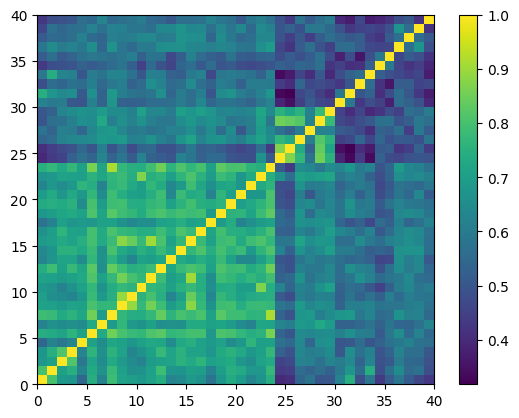

In [9]:
plt.pcolormesh(corrs[6, :, :, 0])
plt.colorbar()
plt.show()

In [10]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

 

2023-03-23 08:55:55.189952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 08:55:55.192294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 08:55:55.192503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
BUFFER_SIZE = corrs.shape[0]
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = (tf
                 .data.Dataset.from_tensor_slices(corrs)
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda



def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(n//4 * n//4 * 256,
                           use_bias=False,
                           input_shape=(n,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((n//4, n//4, 256)))
    assert model.output_shape == (None, n//4, n//4, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5),
                                     strides=(1, 1),
                                     padding='same',
                                     use_bias=False))
    assert model.output_shape == (None, n//4, n//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False))
    assert model.output_shape == (None, n//2, n//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh'))

    # add a layer that sets the diagonal to 1
    # add a layer that symmetrizes the matrix
    
    assert model.output_shape == (None, n, n, 1)

    return model
generator = make_generator_model()

noise = tf.random.normal([1, n])
generated_image = generator(noise, training=False)

plt.pcolormesh(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [ ]:
noise = tf.random.normal([BATCH_SIZE, n])
generated_image = generator(noise, training=False)


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[n, n, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5),
                            strides=(2, 2),
                            padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
#print(decision)
#tf.Tensor([[2.2654163e-05]], shape=(1, 1), dtype=float32)
# This method returns a helper function to compute cross entropy loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),
                              real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),
                              fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),
                         fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 10000
noise_dim = n
num_examples_to_generate = 16

In [ ]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)



seed = tf.random.normal([num_examples_to_generate, noise_dim])
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print ('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(16, 16))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0],vmin=-1,vmax=1,cmap=cm.RdBu_r)
        plt.axis('off')

    plt.savefig('v2_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
#%%time
train(train_dataset, EPOCHS)

In [ ]:
generator.save_weights("generator_n40.h5")
discriminator.save_weights("discriminator_n40.h5")